# Digit Recognition using Neural Networks
This notebook implements a neural network to classify handwritten digits from the MNIST dataset. 
We follow a step-by-step approach 

## Sections:
1. Data Loading and Preprocessing
2. Visualization of data
3. Model Training, Optimization and Visualization
4. Models Evaluation, Comparison and Visualization
5. Conclusion

Libraries used:
- TensorFlow/Keras for building and training the neural network.
- Matplotlib for visualization.
- NumPy for data manipulation.

In [2]:
# Importing essential libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **1. Data Loading and Preprocessing**

### .idx1-ubyte and .idx3-ubyte File Conversion
We will first convert the `.idx1-ubyte` and `.idx3-ubyte` files to CSV format (if not already converted). However, we load dataset directly from the mnist library that is already in the keras as CSV.

The format of the data is `label, pix-11, pix-12, ..., pix-28*28` where `label` is the digit and the rest are pixel values.

then; 

1. Load the MNIST dataset which contains images of digits (28x28 pixels) (built into TensorFlow).
2. Normalize pixel values to a range [0, 1].
3. Reshape data for compatibility with neural networks.
4. Print info about dataset to understand better.

In [3]:
def convert(imgf, labelf, outf, n):
    """
    Convert MNIST idx3-ubyte and idx1-ubyte files into CSV format.
    
    Parameters:
    imgf: str - Path to image file
    labelf: str - Path to label file
    outf: str - Path to output CSV file
    n: int - Number of images to convert
    
    Returns:
    None
    """
    with open(imgf, "rb") as f, open(labelf, "rb") as l, open(outf, "w") as o:
        f.read(16)  # Skip image header
        l.read(8)   # Skip label header
        for i in range(n):
            label = int.from_bytes(l.read(1), byteorder='big')
            image = [int.from_bytes(f.read(1), byteorder='big') for _ in range(28 * 28)]
            o.write(f"{label}," + ",".join(map(str, image)) + "\n")

# convert("train-images.idx3-ubyte", "train-labels.idx1-ubyte", "mnist_train.csv", 60000)
# convert("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte", "mnist_test.csv", 10000)

In [4]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values to the range [0, 1] means pixel values are between 0 and 255
# Her piksel değerini 255.0'a bölmek bu aralığı sağlar.
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape data for CNN (add channel dimension)
# CNN expects data to be in the form of (batch_size, height, width, channels (1 for grayscale, 3 for RGB)) to form a 4D input tensor
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# every image is 28x28 and 1 channel (grayscale) anymore instead of just 28x28

# Reshape for CNN models (28x28x1) in another way
# ... Refers to all existing dimensions to keep them as they are
# np.newaxis increases the dimension of the existing array by one, when used once. It is like placeholder for potential new dimension and 1 by default.
# X_train = X_train[..., np.newaxis]
# X_test = X_test[..., np.newaxis]

# Print dataset shapes
print(f"Training Data Shape: {X_train.shape}, \nTraining Labels Shape: {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, \nTest Labels Shape: {y_test.shape}")

Training Data Shape: (60000, 28, 28, 1), 
Training Labels Shape: (60000,)
Test Data Shape: (10000, 28, 28, 1), 
Test Labels Shape: (10000,)


## **2. Visualization of data**

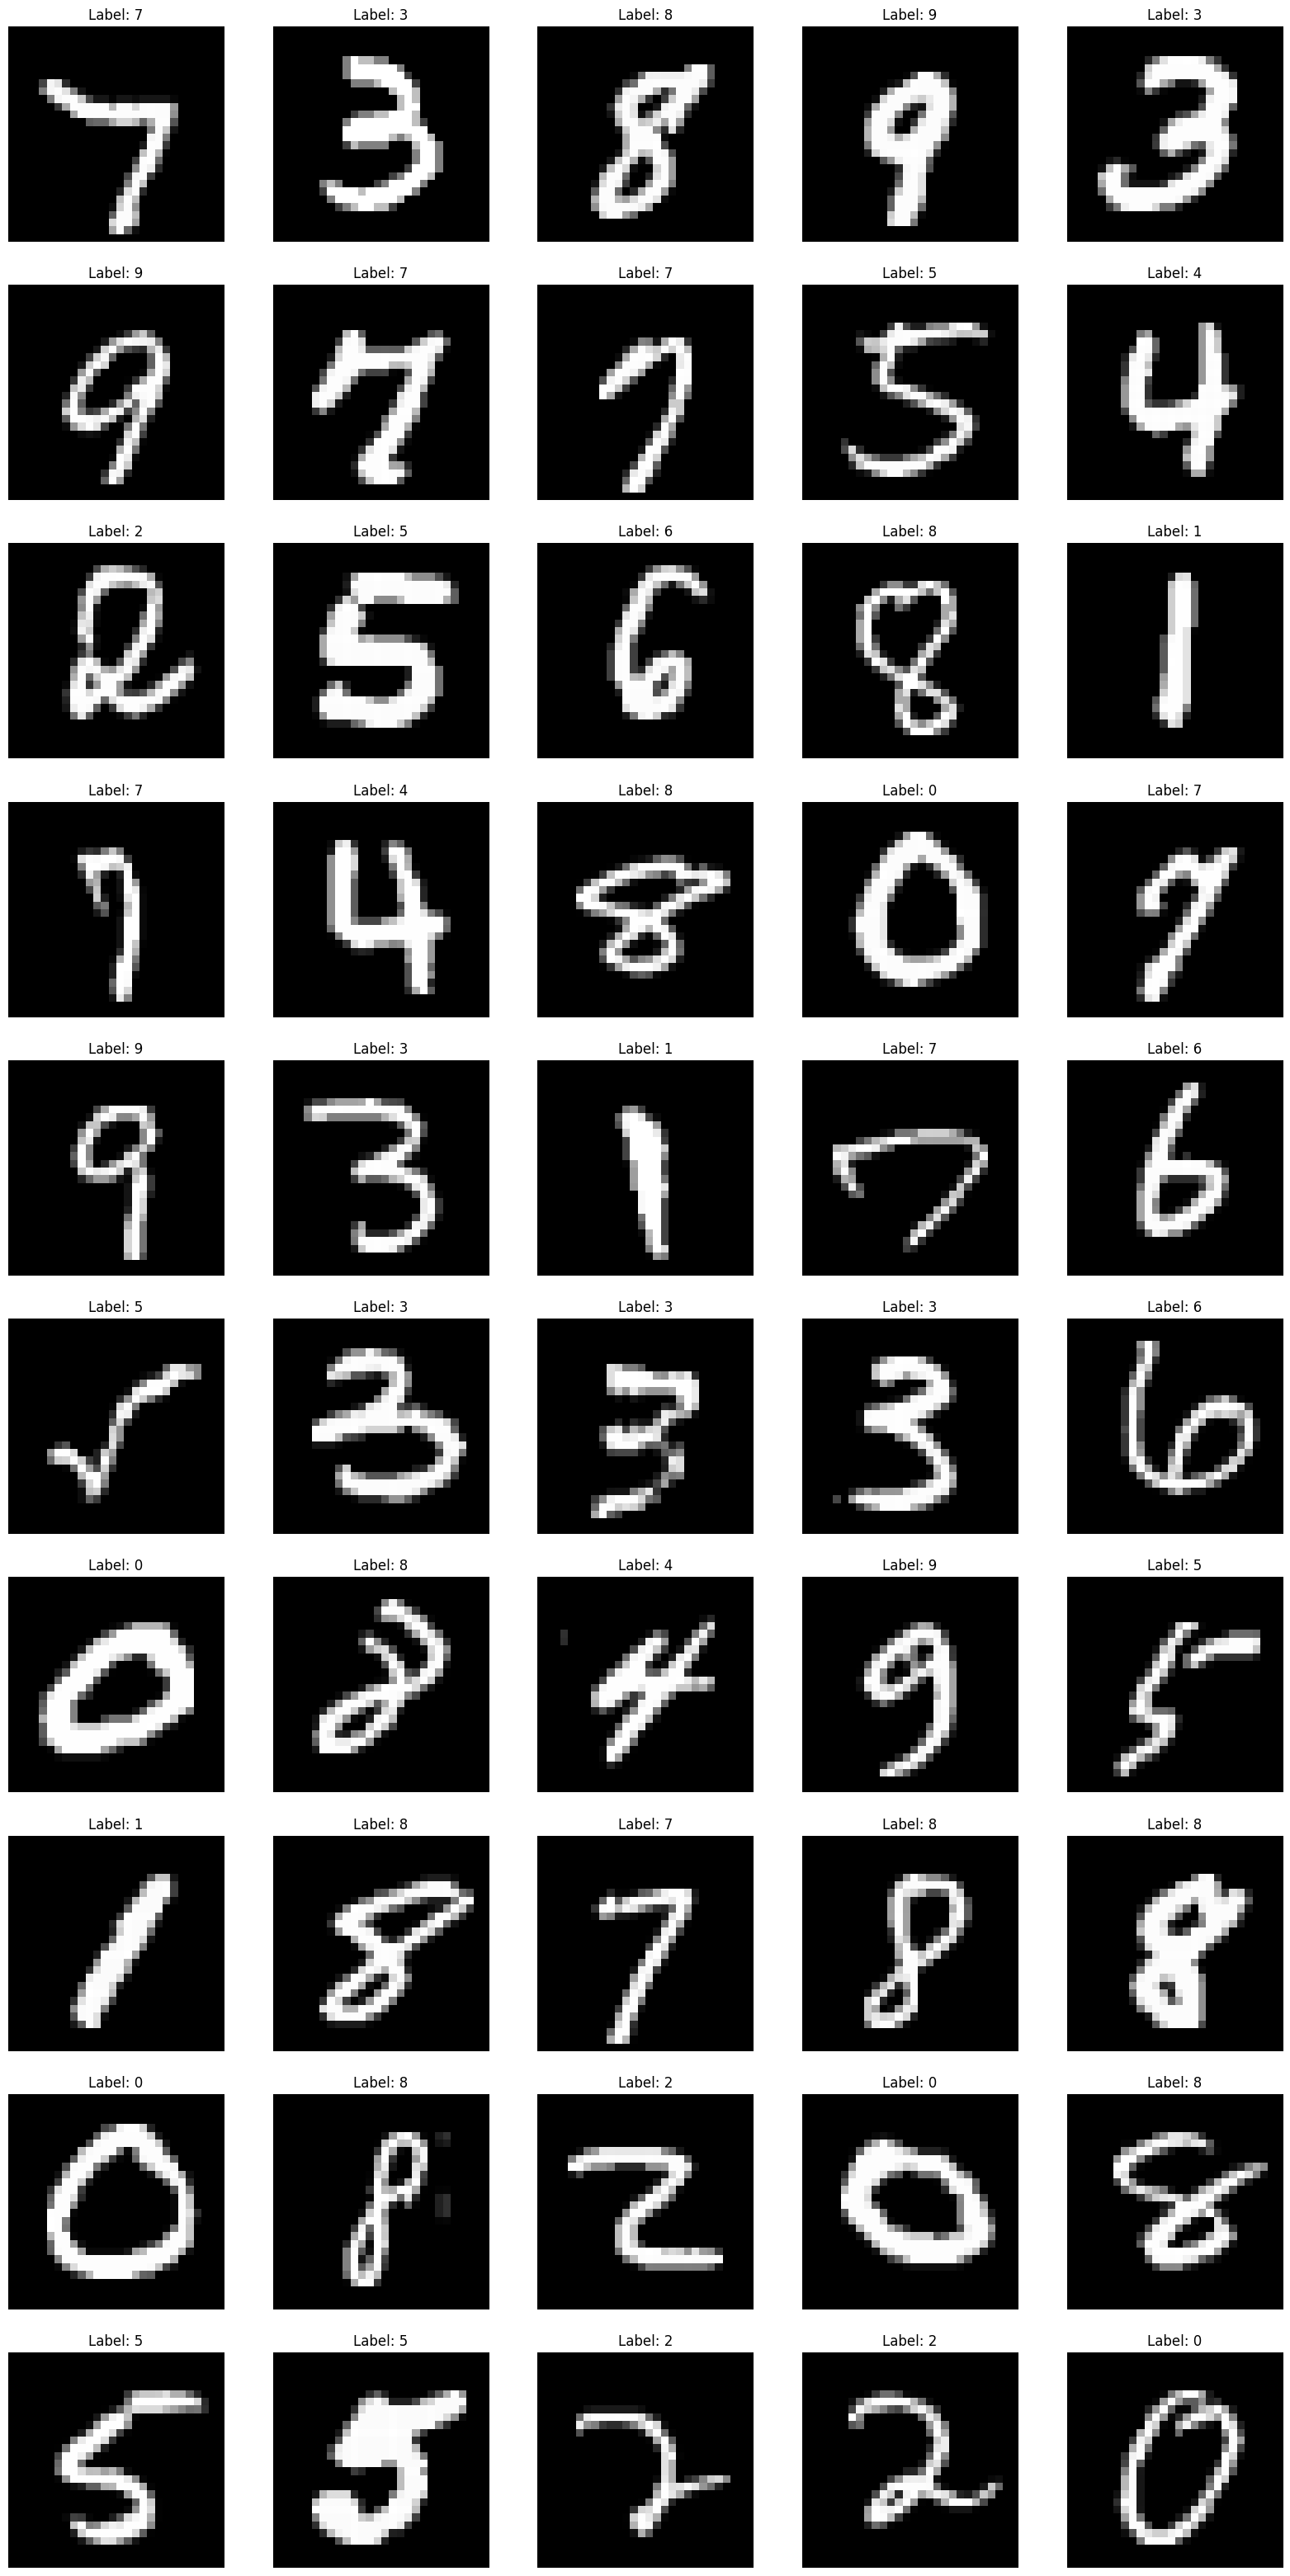

In [ ]:
def visualize_sample(X, y, n=10) -> None:
    """
    Visualize random samples from the dataset.
    
    Parameters:
    X: np.array - Image data
    y: np.array - Label data
    n: int - Number of samples to visualize
    
    Returns:
    None
    """
    fig,axes = plt.subplots(n // 5, 5,figsize=(20, 4 * (n // 5)))
    indices = np.random.choice(range(X.shape[0]), n, replace=False)
    # select n random samples from total number of samples in X, ensures no duplicates
    for i, ax in enumerate(axes.flat):
        # flat makes axes 1D array to iterate over easily
        ax.imshow(X[indices[i]].squeeze(), cmap='gray')
        # squeeze removes the channel dimension (1) from the image shape
        # du matplotlib's imshow function expects 2D image data as doesnt interpret the channel dimension, even it is 3D, it assumes it's an RGB image or multi-channel image by applying default colormap ("fake" RGB channel) to pixel intensities
        # Displays the image in the corresponding subplot
        ax.set_title(f"Label: {y[indices[i]]}")
        ax.axis('off')
    plt.show()

visualize_sample(X_train, y_train)

In [6]:
# ### Helper: Plot Training History
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout() # Adjust the subplots to fit into the figure area.
    plt.show()

## **3. Model Training, Optimization and Visualization**

### **Defining a DNN Model**

 Architecture:
1. Input Layer: Flatten 28x28 pixels into a 1D array of 784 values.
2. Dense Layer: Fully connected with 128 neurons and ReLU activation.
3. Dropout Layer: 20% dropout for regularization.
4. Output Layer: 10 neurons (one for each digit) with softmax activation.

This model serves as a baseline for comparison with CNN models.

Epoch 1/10
750/750 [==============================] - 4s 4ms/step - loss: 0.3736 - accuracy: 0.8923 - val_loss: 0.1825 - val_accuracy: 0.9480
Epoch 2/10
750/750 [==============================] - 3s 3ms/step - loss: 0.1816 - accuracy: 0.9472 - val_loss: 0.1374 - val_accuracy: 0.9591
Epoch 3/10
750/750 [==============================] - 3s 3ms/step - loss: 0.1353 - accuracy: 0.9604 - val_loss: 0.1115 - val_accuracy: 0.9672
Epoch 4/10
750/750 [==============================] - 3s 3ms/step - loss: 0.1105 - accuracy: 0.9674 - val_loss: 0.0973 - val_accuracy: 0.9712
Epoch 5/10
750/750 [==============================] - 2s 3ms/step - loss: 0.0958 - accuracy: 0.9710 - val_loss: 0.0915 - val_accuracy: 0.9728
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 0.0812 - accuracy: 0.9745 - val_loss: 0.0825 - val_accuracy: 0.9748
Epoch 7/10
750/750 [==============================] - 3s 3ms/step - loss: 0.0724 - accuracy: 0.9775 - val_loss: 0.0836 - val_accuracy: 0.9737
Epoch 

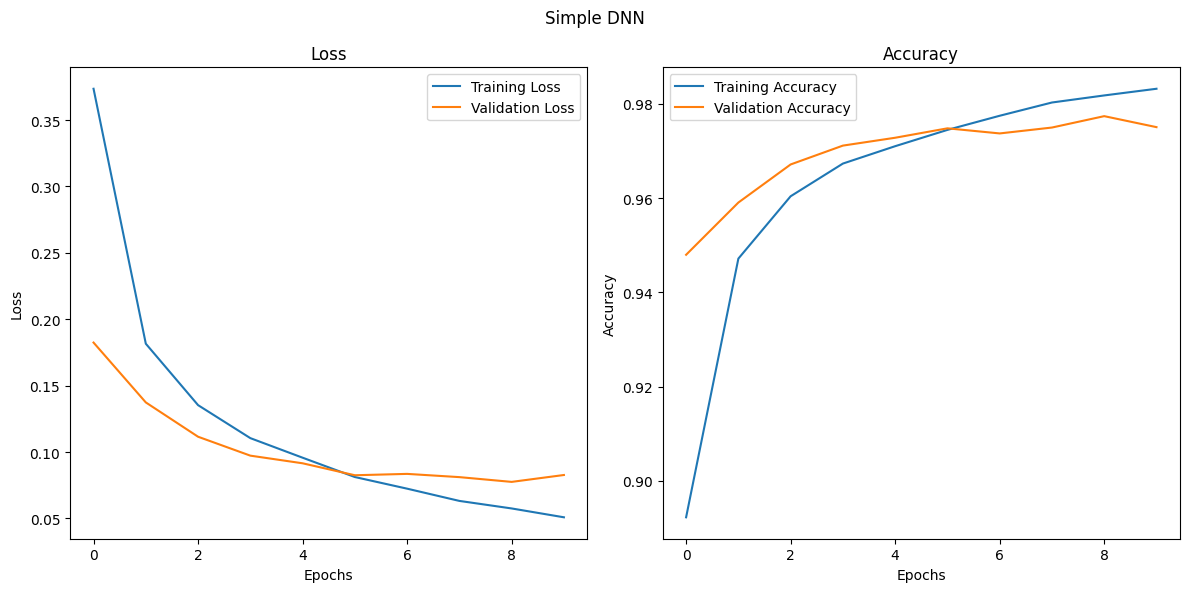

In [7]:
## Implement a Basic Classifier
# A simple feed-forward neural network with one hidden layer


### Model 1: Simple DNN
def create_simple_dnn():
    model = Sequential(
        [
            Flatten(input_shape=(28, 28, 1)),  # Flatten image data
            # converts 2D image data into 1D array as dense layer expects 1D input
            # 28x28x1 -> 784 values in a single row (1D array) that NN can process
            Dense(
                128, activation="relu"
            ),  # Hidden layer learns patterns in data with 128 neurons
            # relu learns non-linear decision boundaries
            Dropout(
                0.2
            ),  # for regularization (prevents overfitting) by randomly disables 20% of neurons in the layer by setting their weights to zero to improve generalization
            Dense(10, activation="softmax"),  # Output layer (10 classes for digits 0-9)
            # scores of each class scaled to [0, 1] and sum to 1 for higher scores of for more likely classes. softmax is used for multi-class classification
            # converts raw predictions into probabilities can be interpreted 
        ]
    )
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    # adam optimizer (adaptive moment estimation): use learning rate that adapts during training. Formula: adam = RMSprop + Momentum 
    # Rmsprop: Root Mean Square Propagation, 
    # Momentum: helps to accelerate gradients vectors in the right directions. 
    # Propagation: It is a method that helps to accelerate the learning process by focusing on the most important parameters. 
    # sparse_categorical_crossentropy: loss function for multi-class classification problems. Computes the cross-entropy loss between true labels and predicted labels in the softmax output layer.
    
    # metrics: observes the model's performance during training and testing. Accuracy is the fraction of correctly classified samples.
    return model


simple_dnn = create_simple_dnn()
history_dnn = simple_dnn.fit(
    X_train, y_train, epochs=10, batch_size=64, validation_split=0.2
)
# batch_size: splits the dataset into mini-batches. Each batch is used to update the model's weights.
# epochs: process of entire dataset n times
# validation_split: reserves a portion of the training data for validation to monitor the model's performance on unseen data during training
plot_training_history(history_dnn, "Simple DNN")

### **Defining a CNN Model**

A CNN is specifically designed for image data and excels at capturing spatial hierarchies (patterns like edges, textures, etc.)


##### CNN Architecture:
1. Convolutional Layer: each 32 conv filters (kernels) scans across 28x28 input (producing feature maps), size of each filter: 3x3 (hxw) to extract local patterns (edges, corners etc) from the input
2. Max Pooling Layer: 2x2 pool size.
3. Convolutional Layer: 64 filters, 3x3 kernel, ReLU activation.
4. Max Pooling Layer: 2x2 pool size.
5. Fully Connected Layer: 128 neurons with ReLU activation.
6. Dropout Layer: 50% dropout.
7. Output Layer: 10 neurons with softmax activation.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

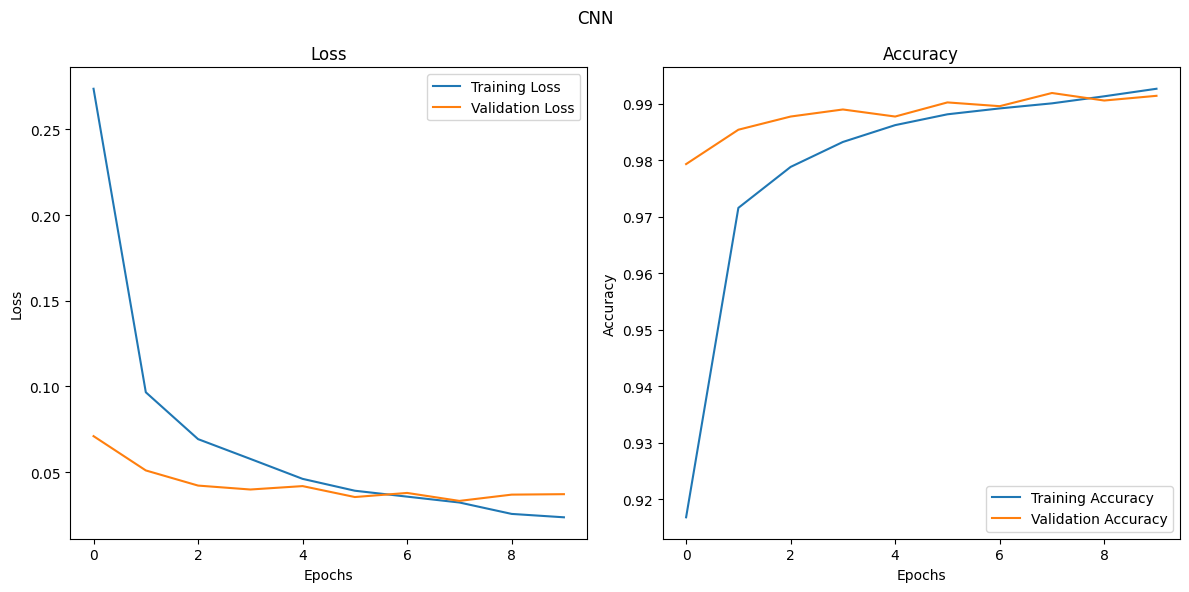

In [8]:
### Model 2: CNN
def create_cnn():
    model = Sequential(
        [  # Sequential model is a linear stack of layers
            Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
            # filters is used to scan the image, kernel_size is the size of the filter. Scanning is done by moving the filter over the image and dot product of the filter is assigned to the output matrix. Output matrix is called feature map and become input for the next layer.
            MaxPooling2D((2, 2)),
            # used to reduce the spatial dimensions of the output volume by taking the maximum value over the window defined by pool_size for each dimension along the features axis.
            Conv2D(64, (3, 3), activation="relu"),
            # learns from input from the previous layer and creates a feature map that identified more complex patterns by increasing the number of filters
            MaxPooling2D((2, 2)),
            Flatten(),
            # converts 3D volume into 1D array to feed into dense layer for classification 5x5x64 -> 1600
            Dense(128, activation="relu"),
            Dropout(0.5),
            # randomly disables 50% of neurons during training to prevent overfitting
            Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    # sparse_categorical_crossentropy: penalizes incorrect predictions more strongly than categorical_crossentropy
    # During training, gradients are computed via backpropagation.
    # Gradients measure how much each weight contributes to the loss.
    # The Adam optimizer uses these gradients to adjust weights, minimizing the loss.

    model.summary()
    return model


cnn = create_cnn()
history_cnn = cnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
plot_training_history(history_cnn, "CNN")

### **Model Optimization**

#### Techniques:
1. Add Batch Normalization after each convolutional layer.
2. Introduce L2 regularization to dense layers.
3. Use a learning rate scheduler for dynamic learning rates.

Epoch 1/15
750/750 [==============================] - 36s 46ms/step - loss: 0.8872 - accuracy: 0.9297 - val_loss: 0.2453 - val_accuracy: 0.9782
Epoch 2/15
750/750 [==============================] - 33s 44ms/step - loss: 0.2672 - accuracy: 0.9682 - val_loss: 0.2206 - val_accuracy: 0.9835
Epoch 3/15
750/750 [==============================] - 31s 42ms/step - loss: 0.2367 - accuracy: 0.9737 - val_loss: 0.2106 - val_accuracy: 0.9783
Epoch 4/15
750/750 [==============================] - 34s 46ms/step - loss: 0.2251 - accuracy: 0.9763 - val_loss: 0.1992 - val_accuracy: 0.9827
Epoch 5/15
750/750 [==============================] - 34s 45ms/step - loss: 0.2173 - accuracy: 0.9778 - val_loss: 0.2003 - val_accuracy: 0.9800
Epoch 6/15
750/750 [==============================] - 32s 43ms/step - loss: 0.2047 - accuracy: 0.9794 - val_loss: 0.1850 - val_accuracy: 0.9848
Epoch 7/15
750/750 [==============================] - 31s 41ms/step - loss: 0.2029 - accuracy: 0.9797 - val_loss: 0.1945 - val_accuracy:

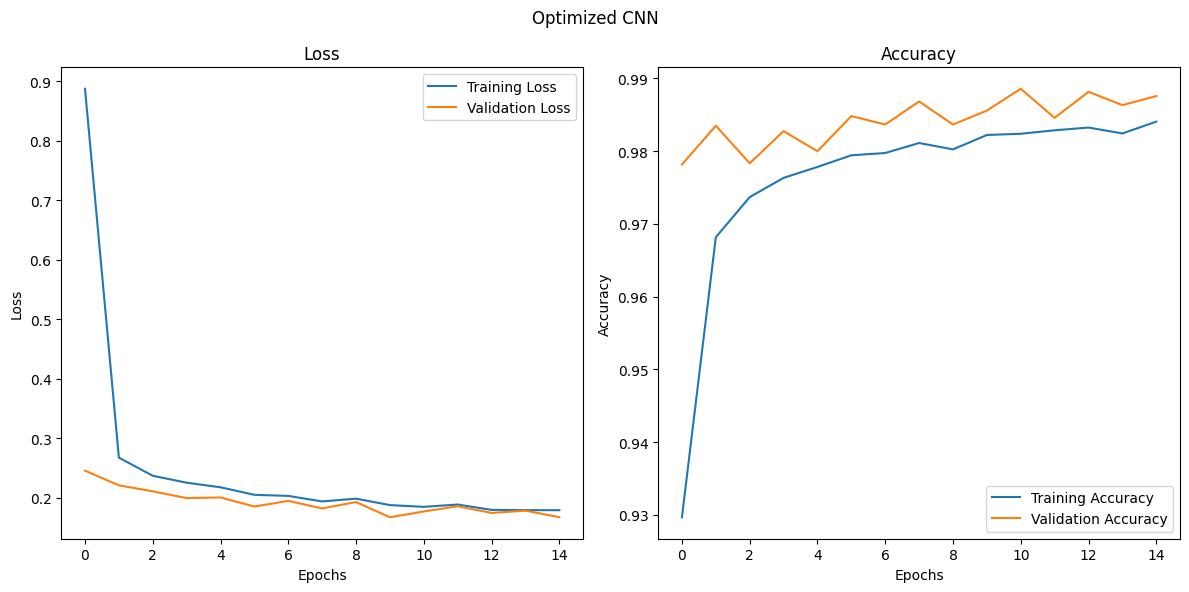

In [9]:
### Model 3: Optimized CNN
def create_optimized_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        BatchNormalization(),
        # Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # L2 regularization: adds a penalty term to the loss function that is proportional to the square of the magnitude of the weights.
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

optimized_cnn = create_optimized_cnn()
history_optimized_cnn = optimized_cnn.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)
plot_training_history(history_optimized_cnn, "Optimized CNN")

## **4. Models Evaluation, Comparison and Visualization**


--- Simple DNN Evaluation ---
Test Loss: 0.08
Test Accuracy: 0.98

--- CNN Evaluation ---
Test Loss: 0.03
Test Accuracy: 0.99

--- Optimized CNN Evaluation ---
Test Loss: 0.16
Test Accuracy: 0.99


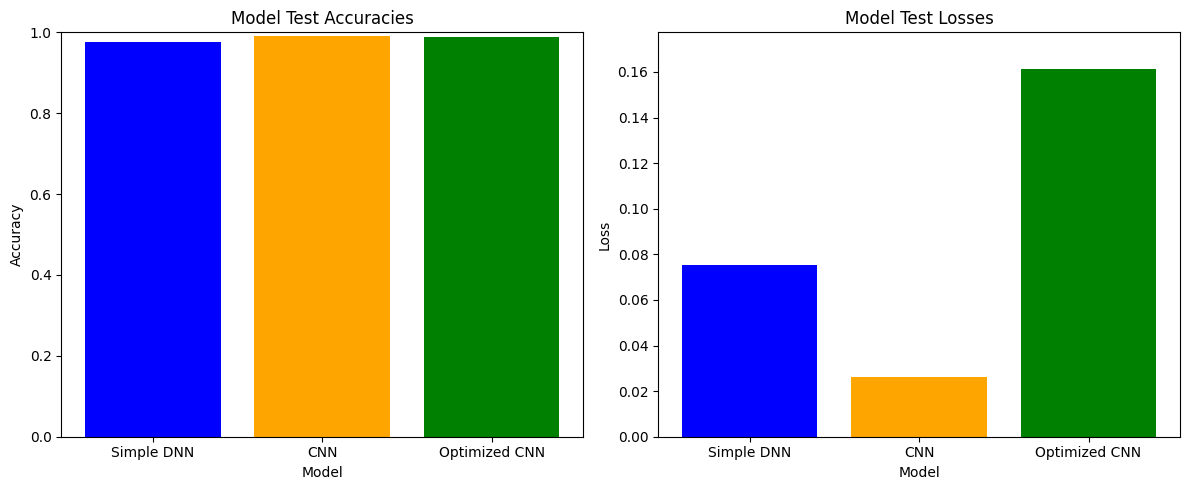

In [16]:
### Evaluate Models
print("\n--- Simple DNN Evaluation ---")
simple_dnn_eval = simple_dnn.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {simple_dnn_eval[0]:.2f}")
print(f"Test Accuracy: {simple_dnn_eval[1]:.2f}")

print("\n--- CNN Evaluation ---")
cnn_eval = cnn.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {cnn_eval[0]:.2f}")
print(f"Test Accuracy: {cnn_eval[1]:.2f}")

print("\n--- Optimized CNN Evaluation ---")
optimized_cnn_eval = optimized_cnn.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {optimized_cnn_eval[0]:.2f}")
print(f"Test Accuracy: {optimized_cnn_eval[1]:.2f}")

# Extract test accuracies and losses
test_accuracies = [
    simple_dnn_eval[1],  # Accuracy of Simple DNN
    cnn_eval[1],         # Accuracy of CNN
    optimized_cnn_eval[1]  # Accuracy of Optimized CNN
]

test_losses = [
    simple_dnn_eval[0],  # Loss of Simple DNN
    cnn_eval[0],         # Loss of CNN
    optimized_cnn_eval[0]  # Loss of Optimized CNN
]


model_names = ['Simple DNN', 'CNN', 'Optimized CNN']
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(model_names, test_accuracies, color=['blue', 'orange', 'green'])
plt.title('Model Test Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xlabel('Model')

# Loss comparison
plt.subplot(1, 2, 2)
plt.bar(model_names, test_losses, color=['blue', 'orange', 'green'])
plt.title('Model Test Losses')
plt.ylabel('Loss')
plt.ylim(0, max(test_losses) * 1.1)  # Dynamic y-axis
plt.xlabel('Model')

plt.tight_layout()
plt.show()

313/313 [==============================] - 2s 6ms/step


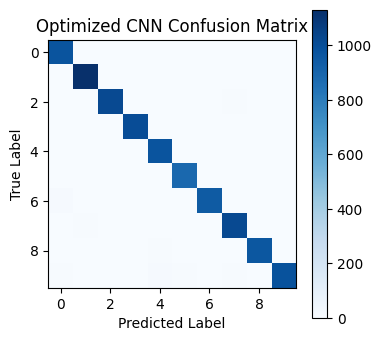

In [14]:
### Confusion Matrix for Best Model
def plot_confusion_matrix(model, X, y_true, title="Confusion Matrix"):
    y_pred = np.argmax(model.predict(X), axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(conf_matrix, cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()
    plt.show()

plot_confusion_matrix(optimized_cnn, X_test, y_test, title="Optimized CNN Confusion Matrix")
# plot_confusion_matrix(cnn, X_test, y_test, title="CNN Confusion Matrix")
# plot_confusion_matrix(simple_dnn, X_test, y_test, title="Simple DNN Confusion Matrix")

#### Compare Results
Compare the performance of the models using accuracy and loss plots.

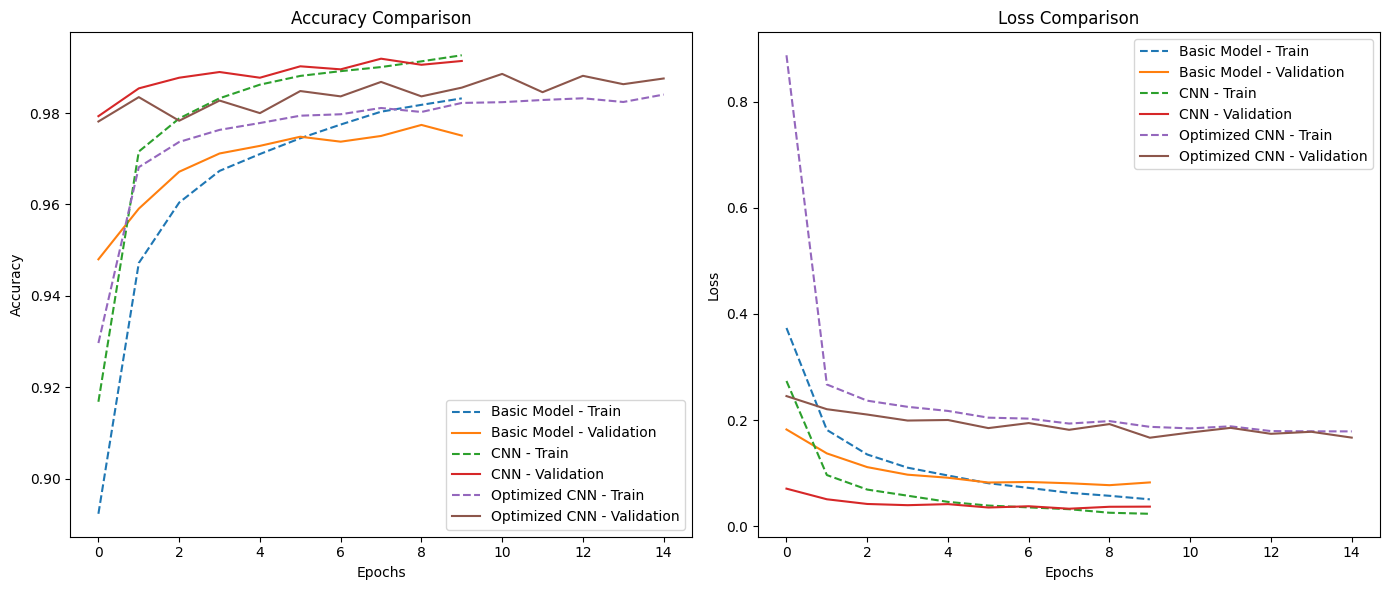

In [12]:
# Plot accuracy and loss for all three models
plt.figure(figsize=(14, 6))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Basic Model - Train', linestyle='--')
plt.plot(history_dnn.history['val_accuracy'], label='Basic Model - Validation')
plt.plot(history_cnn.history['accuracy'], label='CNN - Train', linestyle='--')
plt.plot(history_cnn.history['val_accuracy'], label='CNN - Validation')
plt.plot(history_optimized_cnn.history['accuracy'], label='Optimized CNN - Train', linestyle='--')
plt.plot(history_optimized_cnn.history['val_accuracy'], label='Optimized CNN - Validation')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Basic Model - Train', linestyle='--')
plt.plot(history_dnn.history['val_loss'], label='Basic Model - Validation')
plt.plot(history_cnn.history['loss'], label='CNN - Train', linestyle='--')
plt.plot(history_cnn.history['val_loss'], label='CNN - Validation')
plt.plot(history_optimized_cnn.history['loss'], label='Optimized CNN - Train', linestyle='--')
plt.plot(history_optimized_cnn.history['val_loss'], label='Optimized CNN - Validation')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **5. Conclusion**

### Key Results:
- DNN Test Accuracy: 98%
- CNN Test Accuracy: 99%
- Optimized CNN Test Accuracy: 99%

### Challenges:
1. Balancing model complexity with overfitting.
2. Choosing optimal hyperparameters.

```markdown
---------------------------------------------------
Made By:
Burçin Işık,
Mehmet Özyürek,
Ibrahim Ercoşman

For the Opole University, BOAI lesson lab task.
---------------------------------------------------
```